# Valence Navigator

Goal: To estimate the valence of substitutional defects in crystals.

In [2]:
# fixing autocomplete
%config Completer.use_jedi = False
# better quality plots in notebook
%config InlineBackend.figure_format='retina'
# cell timings
%load_ext autotime
import pandas as pd
from decimal import Decimal
import pickle, os, mplcursors
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from crystal_secrets import *
mpdr = MPDataRetrieval(api_key=secrets['materials_project_api_key'])
import pymatgen
import numpy as np

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


## >> Consider the ionic radii

### >>> Parse data into dataframe

In [360]:
crystal_radii = pd.read_excel('./data/ionic_radii.xls', sheet_name='Wikipedia - Crystal Radii')
effective_radii = pd.read_excel('./data/ionic_radii.xls', sheet_name='Wikipedia - Effective Radii')
symbols = list(crystal_radii.loc[:,'symbol'])
element_names = list(crystal_radii.loc[:,'element'])
spins = []
coords = []
coord_types = []
radii = []
charges = []
all_symbols = []
radial_types = []

for charge in range(-3,9):
    if charge == 0:
        continue
    col = list(crystal_radii.loc[:,charge])
    for item, element_name in zip(col, element_names):
        spin = ''
        if item == '68\xa0ls':
            print(item)
        if '\xa0ls' in element_name:
            spin = 'ls'
        if '\xa0hs' in element_name:
            spin = 'hs'
        coord = 6
        coord_type = ''
        radius = item
        if isinstance(item, str):
            if 'ls' in item:
                spin = 'ls'
            if 'hs' in item:
                spin = 'hs'
            item = item.replace('\xa0ls','').replace('\xa0hs','').replace('−','-')
            radius = item
            if '(' in item:
                if element_name == 'Copper':
                    print("yo")
                if 'sq' in item:
                    coord_type = 'sq'
                if 'py' in item:
                    coord_type = 'py'
                item = item.replace('sq','')
                item = item.replace('py','')
                coord = int(item.split('(')[1].split(')')[0])
                radius = float(item.split('(')[0].strip())
            radii.append(float(radius))
        else:
            radii.append(float(radius))
        spins.append(spin)
        coords.append(coord)
        coord_types.append(coord_type)
        charges.append(charge)
        radial_types.append('crystal')
    all_symbols.extend(symbols)

element_names = list(effective_radii.loc[:,'element'])
symbols = list(effective_radii.loc[:,'symbol'])
for charge in range(-3,9):
    if charge == 0:
        continue
    col = list(effective_radii.loc[:,charge])
    for item, element_name in zip(col, element_names):
        spin = ''
        if '\xa0ls' in element_name:
            spin = 'ls'
        if '\xa0hs' in element_name:
            spin = 'hs'
        coord = 6
        coord_type = ''
        radius = item
        if isinstance(item, str):
            if 'ls' in item:
                spin = 'ls'
            if 'hs' in item:
                spin = 'hs'
            item = item.replace('\xa0ls','').replace('\xa0hs','').replace('−','-')
            radius = item
            if '(' in item:
                if 'sq' in item:
                    coord_type = 'sq'
                if 'py' in item:
                    coord_type = 'py'
                item = item.replace('sq','')
                item = item.replace('py','')
                coord = int(item.split('(')[1].split(')')[0])
                radius = float(item.split('(')[0].strip())
            radii.append(float(radius))
        else:
            radii.append(float(radius))
        spins.append(spin)
        coords.append(coord)
        coord_types.append(coord_type)
        charges.append(charge)
        radial_types.append('effective')
    all_symbols.extend(symbols)

ionic_radii_df = pd.DataFrame()
ionic_radii_df['symbol'] = all_symbols
ionic_radii_df['charge'] = charges
ionic_radii_df['coordination'] = coords
ionic_radii_df['coordination_type'] = coord_types
ionic_radii_df['spin'] = spins
ionic_radii_df['radius/pm'] = radii
ionic_radii_df['radius type'] = radial_types
ionic_radii_df = ionic_radii_df[~pd.isna(ionic_radii_df.loc[:,'radius/pm'])]
ionic_radii_df.reset_index(inplace=True, drop=True)

68 ls


In [361]:
def ionic_radius(element_symbol, charge, radius_type='crystal'):
    results = ionic_radii_df[(ionic_radii_df.loc[:,'symbol'] == element_symbol) & 
                    (ionic_radii_df.loc[:,'radius type'] == r_type) & 
                    (ionic_radii_df.loc[:,'charge'] == charge)]
    if len(results) > 0:
        return float(list(results['radius/pm'])[0])
    else:
        return None

### >>> Run

In [362]:
def parse_chemical_formula(struc):
    sites = struc['sites']
    species = [s['species'][0]['element'] for s in sites]
    species_counts = {elem: species.count(elem) for elem in set(species)}
    return species_counts

def binary_electroneg(parse_struct):
    elements = list(parse_struct.keys())
    electronegs = list(map(lambda x: pymatgen.core.Element(x).X, elements))
    return max(electronegs) - min(electronegs)

In [ ]:
mp_df = pd.read_csv('/Users/juan/Data/Materials Project/mp_all.csv')

In [229]:
structures = list(map(eval, mp_df['structure']))
parsed_structures = list(map(parse_chemical_formula, structures))
mp_df['parsed_structure'] = parsed_structures
mp_df['num_elements'] = list(map(len,parsed_structures))

In [462]:
binary_compounds = mp_df[mp_df['num_elements'] == 2]
min_electroneg = 1.25
triplet_ions = {1: ['Sc','Co'],
            2: ['Ti','Ni'],
            3: ['V','Cu'],
            4: ['Cr','Zn'],
            5: ['Mn'],
            6: ['Fe']}

binary_compounds.insert(loc=0, column='avg_electronegativity',value=list(map(binary_electroneg, list(binary_compounds['parsed_structure']))))
binary_ionic_compounds = binary_compounds[binary_compounds['avg_electronegativity'] > min_electroneg]
struc = binary_ionic_compounds['parsed_structure'].iloc[0]
oxides = binary_ionic_compounds[binary_ionic_compounds['parsed_structure'].apply(lambda x: ('O' in x.keys()) or ('S' in x.keys()) or ('Se' in x.keys()))]

print("Estimating valence of cations ...")
partner_ionizations = []
for oxide in oxides.iterrows():
    elements = list(oxide[1]['parsed_structure'].keys())
    if 'O' in oxide[1]['parsed_structure'].keys():
        n_oxygen = oxide[1]['parsed_structure']['O']
        elements.remove('O')
    elif 'S' in oxide[1]['parsed_structure'].keys():
        n_oxygen = oxide[1]['parsed_structure']['S']
        elements.remove('S')
    else:
        n_oxygen = oxide[1]['parsed_structure']['Se']
        elements.remove('Se')
    partner_element = elements[0]
    n_partner = oxide[1]['parsed_structure'][partner_element]
    i1 = 2 * n_oxygen / n_partner
    if int(i1) != i1:
        i1 = None
    else:
        i1 = int(i1)
    partner_ionizations.append(i1)

# oxides['cation_charge'] = partner_ionizations
oxides.insert(loc=0,column='cation_charge', value= partner_ionizations)

print("Querying the anion radii ...")
# find the ionic radii of the cation in the oxide
cat_radii = []
for row in oxides.iterrows():
    p_structure = dict(row[1]['parsed_structure'])
    if 'O' in p_structure.keys():
        del(p_structure['O'])
    elif 'S' in p_structure.keys():
        del(p_structure['S'])
    else:
        del(p_structure['Se'])
    cation_symbol = list(p_structure.keys())[0]
    cat_charge = row[1]['cation_charge']
    cat_radius = ionic_radius(cation_symbol, cat_charge)
    if cat_radius == None:
        cat_radii.append(np.nan)
    else:
        cat_radii.append(cat_radius)

# oxides['cation_radius'] = cat_radii
oxides.insert(loc=0, column = 'cation_radius', value = cat_radii)

print("Discarding anions with unkown radius ...")
good_oxides = oxides[~np.isnan(oxides['cation_radius'])]
good_oxides.reset_index(inplace=True, drop=True)

print("Calculating replacement of anions ...")

num_chosen = 100
rep_df = pd.DataFrame()
differences = []
hosts = []
guests = []
charges = []
diffs_noabs = []
electronegs = []
for i in range(1,7):
    charged_oxides = good_oxides[good_oxides['cation_charge'] == i]
    for elemens in triplet_ions[i]:
        not_same = np.array([elemens not in x.keys() for x in list(charged_oxides.loc[:,'parsed_structure'])])
        golly_oxides = charged_oxides[not_same]
        defect_radius = ionic_radius(elemens, i)
        if defect_radius:
            rad_diffs = 100*np.abs((golly_oxides['cation_radius'] - defect_radius))/(golly_oxides['cation_radius'])
            rad_diffs_noabs = 100*((golly_oxides['cation_radius'] - defect_radius))/(golly_oxides['cation_radius'])
            sorter = np.argsort(rad_diffs)[:num_chosen]
            differences.extend(rad_diffs.iloc[sorter])
            hosts.extend(golly_oxides.iloc[sorter].loc[:,'pretty_formula'])
            num_finds = len(golly_oxides.iloc[sorter])
            guests.extend([elemens]*num_finds)
            charges.extend([i]*num_finds)
            diffs_noabs.extend(rad_diffs_noabs.iloc[sorter])
            electronegs.extend(golly_oxides.iloc[sorter].loc[:,'avg_electronegativity'])

rep_df.insert(loc=0, column='host', value = hosts)
rep_df.insert(loc=0, column='avg_electronegativity_of_host', value = electronegs)
rep_df.insert(loc=0, column='|rad_diff|/%', value =  differences)
rep_df.insert(loc=0, column='(anion - subs_anion)/%', value =  diffs_noabs)
rep_df.insert(loc=0, column='guest', value =  guests)
rep_df.insert(loc=0, column='cation_charge', value =  charges)
rep_df.drop_duplicates(inplace=True)

print("Sorting by percent radial difference ...")
rep_df.sort_values('|rad_diff|/%', inplace=True)

print("Copying results to clipboard ...")
rep_df.to_clipboard()

Estimating valence of cations ...
Querying the anion radii ...
Discarding anions with unkown radius ...
Calculating replacement of anions ...
Sorting by percent radial difference ...
Copying results to clipboard ...


In [465]:
rep_df

cation_charge guest  (anion - subs_anion)/%  |rad_diff|/%  \
300              3    Cu                0.729927      0.729927   
301              3    Cu               -0.740741      0.740741   
555              6    Fe                1.265823      1.265823   
327              3    Cu                1.449275      1.449275   
100              2    Ni               -2.469136      2.469136   
..             ...   ...                     ...           ...   
578              6    Fe               46.575342     46.575342   
547              5    Mn               47.191011     47.191011   
548              5    Mn               47.777778     47.777778   
550              5    Mn               47.777778     47.777778   
589              6    Fe               55.172414     55.172414   

     avg_electronegativity_of_host   host  
300                           1.56  Co2O3  
301                           1.83  Al2O3  
555                           1.89   MnO3  
327                           1.61  Fe2O3  
100                           1.89    MnO  
..                             ...    ...  
578                           1.28   MoO3  
547                           2.08  Np2O5  
548                           1.42  Bi2O5  
550                           2.06   U2O5  
589                           2.06    UO3  

[117 rows x 6 columns]

In [476]:
import pyperclip

In [482]:
!mkdir calcs

In [483]:
rep_df.to_excel('./calcs/ion_matches.xls')

<ipython-input-483-d99f4073d01f>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  rep_df.to_excel('./calcs/ion_matches.xls')


In [479]:
things = []
for c_charge, host, guest in zip(rep_df.loc[:,'cation_charge'], rep_df.loc[:,'host'], rep_df.loc[:,'guest']):
    kernel = '\ce{%s}^{%d+}\!\!:\!\!' % (guest, c_charge)
    things.append(kernel + '\ce{'+host+'}')
out = '$\n\n$'.join([(', '.join(things[4*i:4*i+4])) for i in range(len(things)//4)])
pyperclip.copy(out)

In [460]:
# matchers = {1: ['Sc','Co'],
#             2: ['Ti','Ni'],
#             3: ['V','Cu'],
#             4: ['Cr','Zn'],
#             5: ['Mn'],
#             6: ['Fe']}
# for i in range(1,7):
#     for elemens in matchers[i]:
#         print('')
#         kernel = '\ce{%s}^{%d+}\!\!:\!\!' % (elemens,i)
#         things = list(set(oxides[oxides['cation_charge'] == i]['pretty_formula']))
#         things = list(map(lambda x: kernel+'\ce{'+x+'}', things))
#         print(', '.join(things))

## Analysis of the Materials Project static database

There is a static version of the Materials Project data from 2018.

https://figshare.com/articles/dataset/Materials_Project_Data/7227749

In [17]:
from matminer.datasets import load_dataset

time: 1.54 ms (started: 2021-08-30 12:08:54 -04:00)


In [4]:
mp_df = pd.read_csv('/Users/juan/Data/Materials Project/mp_all.csv')

In [5]:
structures = list(map(eval, mp_df['structure']))

In [6]:
def parse_chemical_formula(struc):
    sites = struc['sites']
    species = [s['species'][0]['element'] for s in sites]
    species_counts = {elem: species.count(elem) for elem in set(species)}
    return species_counts

In [7]:
parsed_structures = list(map(parse_chemical_formula, structures))

In [8]:
mp_df['parsed_structure'] = parsed_structures
mp_df['num_elements'] = list(map(len,parsed_structures))

In [9]:
binary_compounds = mp_df[mp_df['num_elements'] == 2]

In [14]:
def binary_electroneg(parse_struct):
    elements = list(parse_struct.keys())
    electronegs = list(map(lambda x: pymatgen.core.Element(x).X, elements))
    return max(electronegs) - min(electronegs)

In [23]:
list(list(binary_compounds['parsed_structure'])[0].keys())

['Ce', 'Hg']

In [16]:
binary_compounds['avg_electronegativity'] = list(map(binary_electroneg, list(binary_compounds['parsed_structure'])))

<ipython-input-16-a2d88e0d90d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_compounds['avg_electronegativity'] = list(map(binary_electroneg, list(binary_compounds['parsed_structure'])))


In [17]:
binary_ionic_compounds = binary_compounds[binary_compounds['avg_electronegativity']>2]

In [18]:
struc = binary_ionic_compounds['parsed_structure'].iloc[0]

In [19]:
oxides = binary_ionic_compounds[binary_ionic_compounds['parsed_structure'].apply(lambda x: 'O' in x.keys())]

In [20]:
partner_ionizations = []
for oxide in oxides.iterrows():
    n_oxygen = oxide[1]['parsed_structure']['O']
    elements = list(oxide[1]['parsed_structure'].keys())
    elements.remove('O')
    partner_element = elements[0]
    n_partner = oxide[1]['parsed_structure'][partner_element]
    i1 = 2*n_oxygen/n_partner
    if int(i1) != i1:
        i1 = None
    else:
        i1 = int(i1)
    partner_ionizations.append(i1)

In [21]:
oxides['cation_charge'] = partner_ionizations

<ipython-input-21-624b8993212a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxides['cation_charge'] = partner_ionizations


In [22]:
matchers = {1: ['Sc','Co'],
            2: ['Ti','Ni'],
            3: ['V','Cu'],
            4: ['Cr','Zn'],
            5: ['Mn'],
            6: ['Fe']}
for i in range(1,7):
    for elemens in matchers[i]:
        print('')
        kernel = '\ce{%s}^{%d+}\!\!:\!\!' % (elemens,i)
        things = list(set(oxides[oxides['cation_charge'] == i]['pretty_formula']))
        things = list(map(lambda x: kernel+'\ce{'+x+'}', things))
        print(', '.join(things))


\ce{Sc}^{1+}\!\!:\!\!\ce{Zr2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{K2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Li2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Cs2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Sm2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Na2O}, \ce{Sc}^{1+}\!\!:\!\!\ce{Rb2O}

\ce{Co}^{1+}\!\!:\!\!\ce{Zr2O}, \ce{Co}^{1+}\!\!:\!\!\ce{K2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Li2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Cs2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Sm2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Na2O}, \ce{Co}^{1+}\!\!:\!\!\ce{Rb2O}

\ce{Ti}^{2+}\!\!:\!\!\ce{Na2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{NdO}, \ce{Ti}^{2+}\!\!:\!\!\ce{YbO}, \ce{Ti}^{2+}\!\!:\!\!\ce{K2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{CeO}, \ce{Ti}^{2+}\!\!:\!\!\ce{UO}, \ce{Ti}^{2+}\!\!:\!\!\ce{SmO}, \ce{Ti}^{2+}\!\!:\!\!\ce{CaO}, \ce{Ti}^{2+}\!\!:\!\!\ce{Rb2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{PuO}, \ce{Ti}^{2+}\!\!:\!\!\ce{Li2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{HoO}, \ce{Ti}^{2+}\!\!:\!\!\ce{NpO}, \ce{Ti}^{2+}\!\!:\!\!\ce{EuO}, \ce{Ti}^{2+}\!\!:\!\!\ce{BaO}, \ce{Ti}^{2+}\!\!:\!\!\ce{Cs2O2}, \ce{Ti}^{2+}\!\!:\!\!\ce{ZrO}, \ce{Ti}^{2+}\!\!:\

In [8]:
mp_df = load_dataset('mp_all_20181018')

In [18]:
another_df = load_dataset('mp_all_20181018')

time: 12min 52s (started: 2021-08-30 12:11:17 -04:00)


In [20]:
adf = pd.read_pickle('/Users/juan/Google Drive/Zia Lab/Codebase/qdef/data/mp_2018.pkl')

time: 8min 30s (started: 2021-08-30 13:33:45 -04:00)


In [7]:
import json

In [ ]:
with open("/Users/juan/Downloads/mp_all.json", encoding="utf-8") as infile:
    mp_df = json.load(infile)

## Fun functions & Parsing

In [3]:
def some_in_list(l1,l2):
    return sum([L1 in l2 for L1 in l1]) > 0

In [4]:
def spinless(abundance):
    '''This function returns a list of atoms with 
    at least the provided spinless natural abundance'''
    spin_less_and_plenty = all_spinless[all_spinless['nat_spinless_abundance']>=abundance]
    return spin_less_and_plenty.index.tolist()
def spinfull(abundance):
    spineless = spinless(abundance)
    return [s for s in all_at_symbols if s not in spineless]

In [5]:
all_at_symbols = ['Ac','Ag','Al','Am','Ar','As','At','Au','B','Ba','Be','Bh',
                  'Bi','Bk','Br','C','Ca','Cd','Ce','Cf','Cl','Cm','Cn','Co',
                  'Cr','Cs','Cu','Db','Ds','Dy','Er','Es','Eu','F','Fe','Fl',
                  'Fm','Fr','Ga','Gd','Ge','H','He','Hf','Hg','Ho','Hs','I',
                  'In','Ir','K','Kr','La','Li','Lr','Lu','Lv','Mc','Md','Mg',
                  'Mn','Mo','Mt','N','Na','Nb','Nd','Ne','Nh','Ni','No','Np',
                  'O','Og','Os','P','Pa','Pb','Pd','Pm','Po','Pr','Pt','Pu',
                  'Ra','Rb','Re','Rf','Rg','Rh','Rn','Ru','S','Sb','Sc','Se',
                  'Sg','Si','Sm','Sn','Sr','Ta','Tb','Tc','Te','Th','Ti','Tl',
                  'Tm','Ts','U','V','W','Xe','Y','Yb','Zn','Zr']
spindata = open('spinData.txt','r').read()
spindata = [l.strip().split() for l in spindata.split('\n') if '%' not in l]
allSpin = []
for spinDatum in spindata:
    spindict = {'atomic_number':int(spinDatum[0]),
               'nucleons':int(spinDatum[1]),
               'radioactive':spinDatum[2],
               'symbol':spinDatum[3],
               'name':spinDatum[4],
               'spin':Decimal(spinDatum[5]).as_integer_ratio(),
               'g_nuclear':float(spinDatum[6]),
               'nat_abundance':float(spinDatum[7])/100., 
               'e_quad_moment':float(spinDatum[8])}
    spindict['radioactive'] = (spindict['radioactive'] == '*')
    allSpin.append(spindict)
spinData = pd.DataFrame(allSpin)

In [6]:
# for each atomic number compute the natural abundance of spinless atoms
all_spinless = []
for at_number in list(set(spinData['atomic_number'])):
    this_group = spinData[spinData['atomic_number']==at_number]
    symb = list(this_group['symbol'])[0]
    name = list(this_group['name'])[0]
    this_group = this_group[this_group['spin'] == Decimal('0').as_integer_ratio()]
    this_ab = np.sum(this_group['nat_abundance'])

    this_dict = {'atomic_number': at_number,
                 'symbol': symb,
                 'name': name,
                 'nat_spinless_abundance': this_ab}
    all_spinless.append(this_dict)
all_spinless = pd.DataFrame(all_spinless)
all_spinless.set_index('symbol', inplace=True)

In [15]:
all_spinless.to_json('/Users/david/Google Drive/Zia Lab/Codebase/qdef/all_spinless.json')

In [ ]:
pd.read_json('/Users/david/Google Drive/Zia Lab/Codebase/qdef/all_spinless.json')

In [7]:
ferrenti = pickle.load(open('ferrenti.pkl','rb'))
ferrenti_df = pd.read_excel('/Users/david/Google Drive/Zia Lab/Log/Data/Ferrenti 2020.xlsx', usecols=range(18))
ferrenti_df = ferrenti_df[ferrenti_df['Ferrenti 2020'] > 0]
ferrenti_ids = [l for l in ferrenti_df['Materials ID'].to_list() if 'mp-' in l]

In [8]:
criteria = {'material_id':{'$in': ferrenti_ids}}
props = ['band_gap','cif','elements','pretty_formula',
         'density','nelements', 'structure','spacegroup',
        'e_above_hull','icsd_ids','formation_energy_per_atom']
ferrenti_gt = mpdr.get_dataframe(criteria=criteria, properties=props)

  0%|          | 0/537 [00:00<?, ?it/s]

In [10]:
ferrenti_gt.to_pickle('/Users/david/Google Drive/Zia Lab/Codebase/qdef/data/ferrenti_gt.pkl')

In [539]:
pkl_fname = os.path.join(data_dir,'ferrenti_gt.pkl')
pickle.dump(ferrenti_gt,open(pkl_fname,'wb'))

In [11]:
ferrenti_gtt = pd.read_pickle('/Users/david/Google Drive/Zia Lab/Codebase/qdef/data/ferrenti_gt.pkl')

## Queries

In [211]:
def crystal_sieve(sieve_parameters):
    if sieve_parameters['element_selection'][0] == 'natural':
        return crystal_sieve_natural(sieve_parameters)
    elif sieve_parameters['element_selection'][0] == 'manual':
        return crystal_sieve_manual(sieve_parameters)
    else:
        print("Invalid choice for element selection.")
        return None
def crystal_sieve_natural(sieve_parameters):
    spinless_abundance = sieve_parameters['element_selection'][1]
    min_gap, max_gap = sieve_parameters['bandgap_interval']
    num_ingredients = list(range(sieve_parameters['num_ingredients'][0],
                                 sieve_parameters['num_ingredients'][1]+1))
    ####################################################################
    print("Filtering for elements with a natural spinless isotopic abundance equal or greater than %.1f%%." % (100*spinless_abundance))
    sieve_parameters['allowed_elements'] = spinless(spinless_abundance)
    sieve_parameters['not_allowed_elements'] = spinfull(spinless_abundance)
    print("There are %d elements matching this criterion." % len(sieve_parameters['allowed_elements']))
    ####################################################################
    print("Searching the Materials Project...")
    criteria = {'band_gap':{'$gte':min_gap,'$lte':max_gap},
                'nelements': {'$in': num_ingredients},
                'elements':{'$in':sieve_parameters['allowed_elements'],
                            '$nin':sieve_parameters['not_allowed_elements']}}
    props = ['band_gap','cif','elements','pretty_formula',
             'density','nelements', 'structure','spacegroup',
            'e_above_hull','icsd_ids','formation_energy_per_atom']
    sieve_parameters['search_results'] = mpdr.get_dataframe(criteria=criteria,
                     properties=props)
    sieve_parameters['search_results']['polar'] = [s['point_group'] in polar_point_groups for s in sieve_parameters['search_results']['spacegroup']]
    sieve_parameters['search_results']['contains_unviable_elements'] = sieve_parameters['search_results']['elements'].apply(lambda x: some_in_list(x, sieve_parameters['unviable_elements']))
    return sieve_parameters
def crystal_sieve_manual(sieve_parameters):
    return "Hello manual."

In [347]:
sieve_parameters = {
    'element_selection': ('natural',0.50),
    'bandgap_interval': (0.5,6.25),
    'space_group_syms': ('auto'),
    'max_e_above_hull': 0.2,
    'num_ingredients': (1,5),
    'unviable_elements': ['Ce','Nd','Sm','Gd','Dy','Er','Yb','Th',
                          'U','Cd','Hg','He','Ne','Ar','Kr','Xe']
}
sieve_parameters = crystal_sieve(sieve_parameters)

Filtering for elements with a natural spinless isotopic abundance equal or greater than 50.0%.
There are 42 elements matching this criterion.
Searching the Materials Project...


  0%|          | 0/5380 [00:00<?, ?it/s]

In [348]:
data_dir = '/Users/david/Google Drive/Zia Lab/Log/Data'
pkl_fname = os.path.join(data_dir,'crystal_search-%d.pkl' % int(time.time()))
pickle.dump(sieve_parameters,open(pkl_fname,'wb'))
print(pkl_fname)

/Users/david/Google Drive/Zia Lab/Log/Data/crystal_search-1613093038.pkl


In [356]:
# apply additional filters
good_ones = (~sieve_parameters['search_results']['contains_unviable_elements']
            & ~sieve_parameters['search_results']['polar']
            & (sieve_parameters['search_results']['e_above_hull'] < sieve_parameters['max_e_above_hull'])
            & (sieve_parameters['search_results']['icsd_ids'].apply(lambda x: len(x) > 0))
            & ((sieve_parameters['search_results']['pretty_formula'] != 'SiO2') | (sieve_parameters['search_results'].index == 'mp-7000'))
            )
crystals_found = sieve_parameters['search_results'][good_ones]
crystals_found['in_ferrenti'] = crystals_found.index.map(lambda x: x in ferrenti_df['Materials ID'].to_list())
pretty_dictionary = crystals_found['pretty_formula'].to_dict()
pretty_formulas = crystals_found['pretty_formula'].to_list()
crystals_found['with_same_stoichiometry'] = crystals_found['pretty_formula'].apply(lambda x: [i for i in pretty_dictionary if pretty_dictionary[i] == x])
crystals_found['with_same_stoichiometry_len'] = crystals_found['with_same_stoichiometry'].apply(len)
crystals_found['spacegroup_symbol'] = crystals_found['spacegroup'].apply(lambda x: x['symbol'])
print('%d crystals found!'% len(crystals_found))
print('%d of them have different stoichiometry' % len(set((crystals_found['pretty_formula']))))
print('%d of them match with Ferrenti (which includes %d hosts)' % (sum(crystals_found['in_ferrenti']),len(ferrenti_df)))

1073 crystals found!
718 of them have different stoichiometry
522 of them match with Ferrenti (which includes 541 hosts)


In [433]:
# compute sets as a function of spinless abundance and bandgap estimate
spinlessness = np.linspace(0.4,1,50)
bgaps = np.linspace(2.0,5.5,50)
howmany = []
howmanyf = []
for ab in spinlessness:
    howmanyrow = []
    howmanyrowformulae = []
    for bgap in bgaps:
        accept = spinless(ab)
        found = (set(crystals_found[(crystals_found['elements'].apply(lambda x: len(x) == len(set(x).intersection(accept)))
                       & (crystals_found['band_gap']>bgap))]['pretty_formula']))
        howmanyrow.append(len(found))
        howmanyrowformulae.append(list(found))
    howmany.append(howmanyrow)
    howmanyf.append(howmanyrowformulae)
howmany = np.array(howmany)

In [495]:
def compounds(ab,bg):
    i = np.argmin(np.abs(spinlessness-ab))
    j = np.argmin(np.abs(bgaps-bg))
    r = sorted(howmanyf[i][j])
    if len(r) > 10:
        return ',\n'.join(r[:10]) + ('\n(%d more)...' % (len(r)-10))
    else:
        return ',\n'.join(r)

In [542]:
rhom = 4.09
mmass = 97.5
rhomol = rhom/mmass * 6.02e23 * 1e-21 # in particles per cubic nanometer
print('%.3f nm' % (1/(rhomol**(1/3))))

0.341 nm


<IPython.core.display.Javascript object>


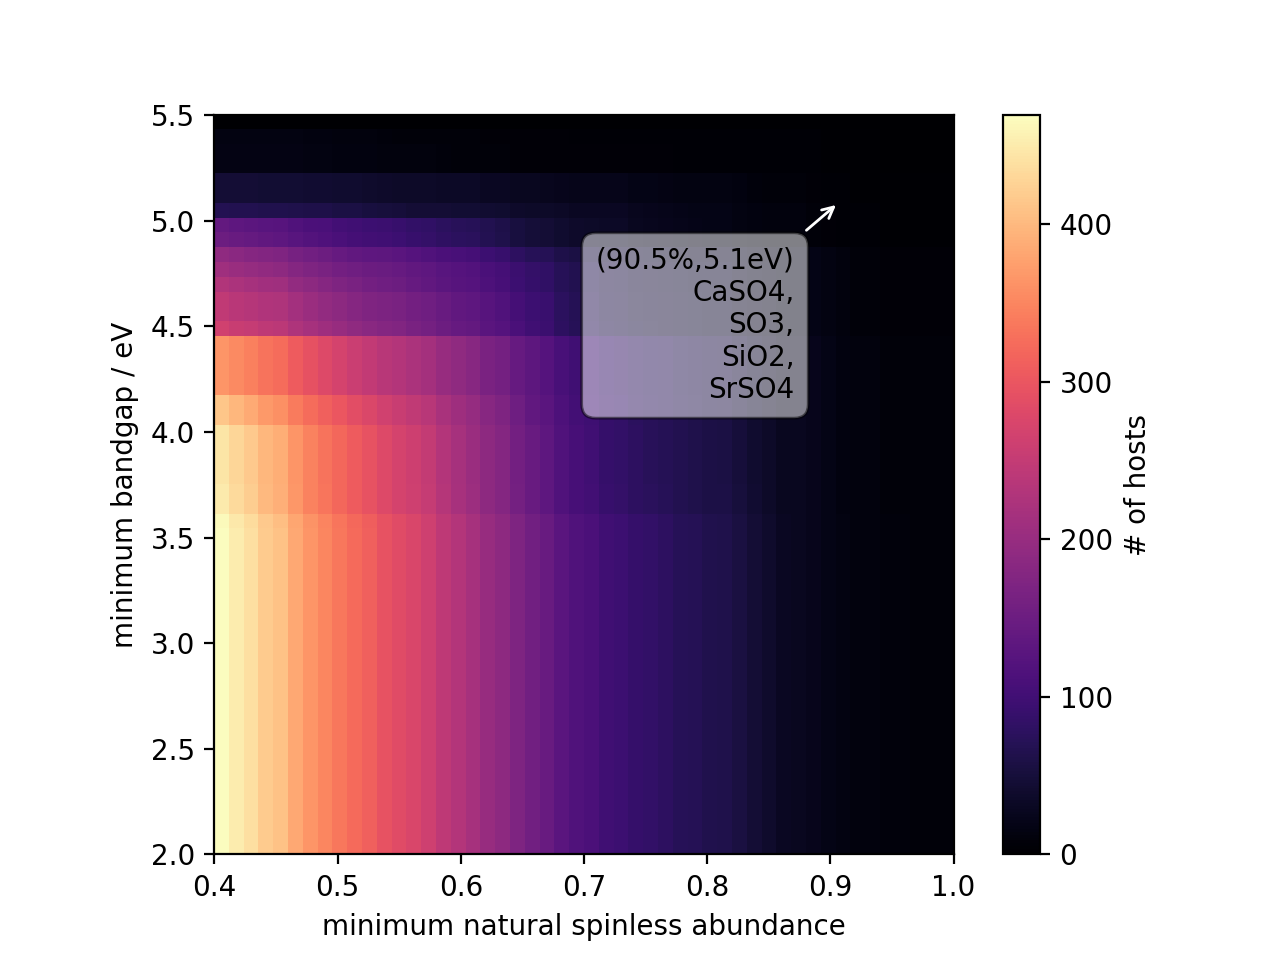

In [537]:
plt.figure()
hmap = plt.imshow(howmany,extent=[spinlessness[0],
                          spinlessness[-1],
                          bgaps[0],
                          bgaps[-1]], origin='lower',
          cmap='magma',
          aspect=1/((bgaps[-1]-bgaps[0])/(spinlessness[-1]-spinlessness[0])))
cbar = plt.colorbar()
cbar.set_label('# of hosts')
# mplcursors.cursor(hover=False,annotation_kwargs={'text':'y','xytext':(0.5,3)})
cursor = mplcursors.cursor(hover=False)
@cursor.connect("add")
def on_add(sel):
    ann = sel.annotation
    x, y = ann.xy
    anntxt = ('(%.1f%%,%.1feV)\n' % (x*100,y))+compounds(x,y)
    ann.arrowprops['ec'] = 'w'
    ann.set_backgroundcolor('white')
    ann.set_text(anntxt)
plt.xlabel('minimum natural spinless abundance')
plt.ylabel('minimum bandgap / eV')
plt.show()

# Old Stuff

In [2]:
mpdr = MPDataRetrieval(api_key='023o1DArkeOFQz8T')

In [ ]:
properties = ['density',]

In [15]:
df = mpdr.get_dataframe(criteria={"nelements": 1}, properties=['cif'])
print("There are {} entries on MP with 1 element".format(df['cif'].count()))

  0%|          | 0/716 [00:00<?, ?it/s]

There are 716 entries on MP with 1 element


In [19]:
print(df.iloc[0]['cif'])

# generated using pymatgen
data_Cs
_symmetry_space_group_name_H-M   'P 1'
_cell_length_a   5.29144986
_cell_length_b   5.29144986
_cell_length_c   5.29144986
_cell_angle_alpha   109.47122063
_cell_angle_beta   109.47122063
_cell_angle_gamma   109.47122063
_symmetry_Int_Tables_number   1
_chemical_formula_structural   Cs
_chemical_formula_sum   Cs1
_cell_volume   114.05180544
_cell_formula_units_Z   1
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Cs  Cs0  1  0.00000000  0.00000000  0.00000000  1



In [66]:
props = ['band_gap','cif','density','doi','e_above_hull','efermi','elements',
         'full_formula','final_energy','piezo','pretty_formula','pseudo_potential',
        'reduced_cell_formula','structure','spacegroup','tags','warnings']
results = mpdr.get_dataframe(criteria={"material_id": 'mp-1102227'},
         properties=props)

In [63]:
with open('tempcif.cif','w') as file:
    file.write(results['cif'][0])

In [65]:
!open tempcif.cif

In [67]:
props = ['band_gap','cif','pretty_formula',
        'structure','spacegroup']
results = mpdr.get_dataframe(criteria={"material_id": 'mp-1102227'},
         properties=props)

In [68]:
results

band_gap                                                cif  \
material_id                                                                
mp-1102227     6.4314  # generated using pymatgen\ndata_CO2\n_symmetr...   

            pretty_formula                                          structure  \
material_id                                                                     
mp-1102227             CO2  [[5.01249416 0.05681684 5.42401875] C, [0.0568...   

                                                    spacegroup  
material_id                                                     
mp-1102227   {'symprec': 0.1, 'source': 'spglib', 'symbol':...

# More Elaborate Queries with mongoDB syntax

https://docs.mongodb.com/v2.6/reference/operator/query/

In [106]:
min_bandgap, max_bandgap = 5, 6
good_atoms = ["Ca","C","O"]
bad_atoms = ["Rb","Si"]
criteria = {'band_gap':{'$gte':min_bandgap,'$lte':max_bandgap},
            'elements':{'$in':good_atoms,'$nin':bad_atoms}}
props = ['band_gap','cif','pretty_formula','density','nelements',
        'structure','spacegroup']
results = mpdr.get_dataframe(criteria=criteria,
         properties=props)

  0%|          | 0/1546 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


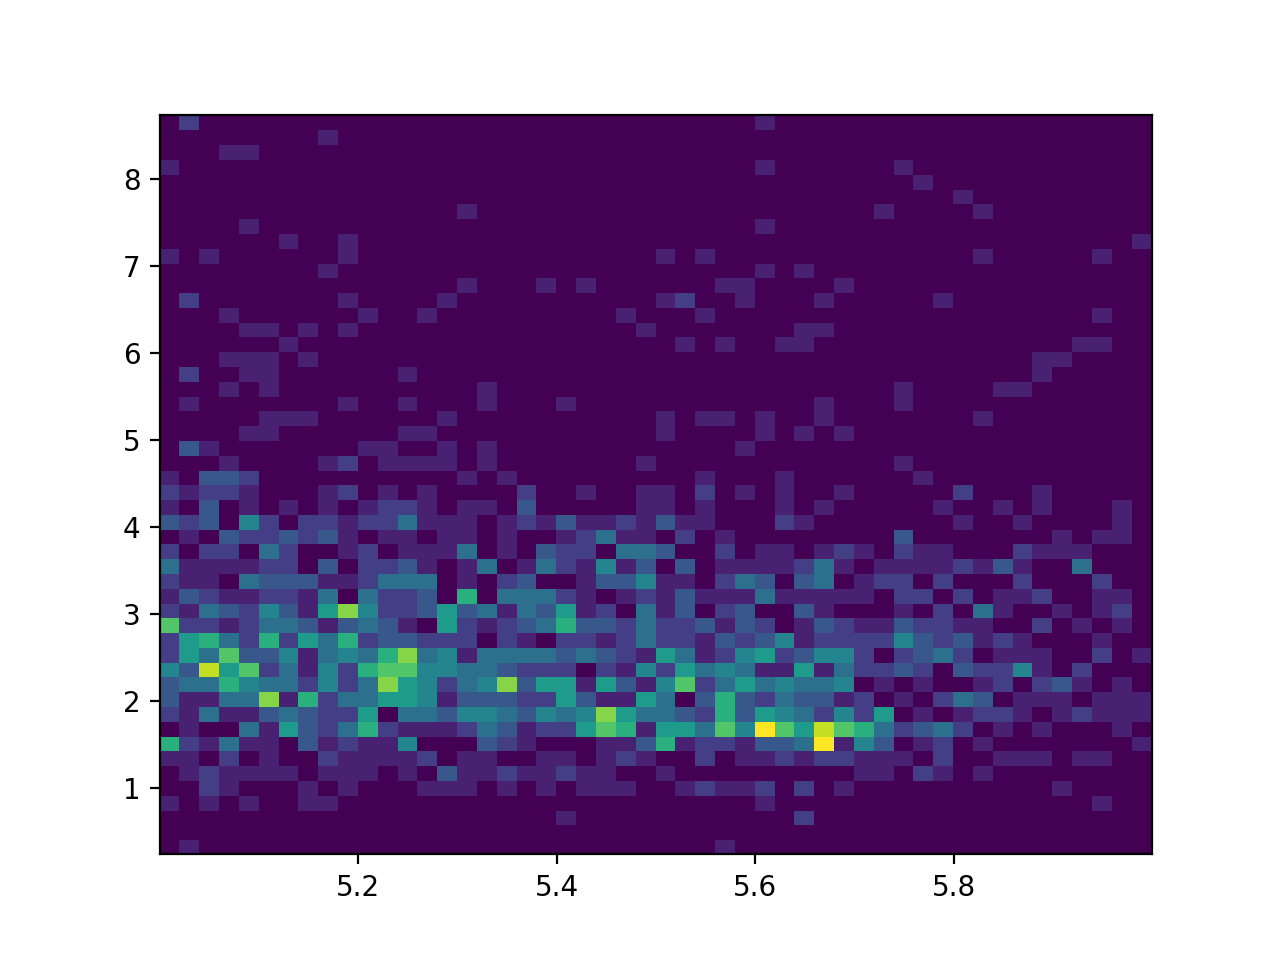

In [103]:
plt.figure()
plt.hist2d(results['band_gap'],results['density'],bins=50)
plt.show()

<IPython.core.display.Javascript object>


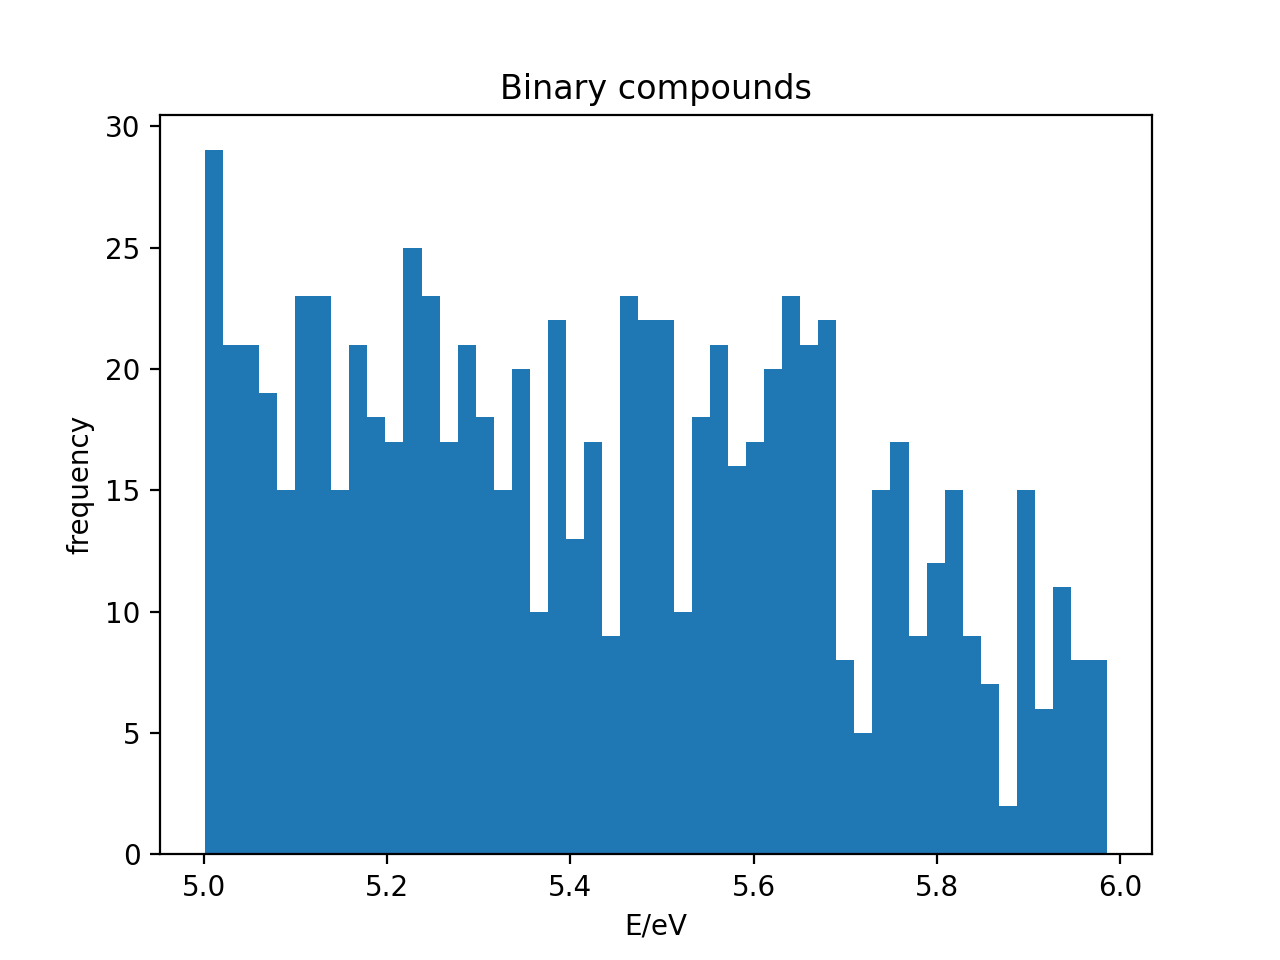

In [97]:
plt.figure()
plt.hist(results['band_gap'][results['nelements']==3],bins=50)
plt.xlabel('E/eV')
plt.ylabel('frequency')
plt.title('Binary compounds')
plt.show()

<IPython.core.display.Javascript object>


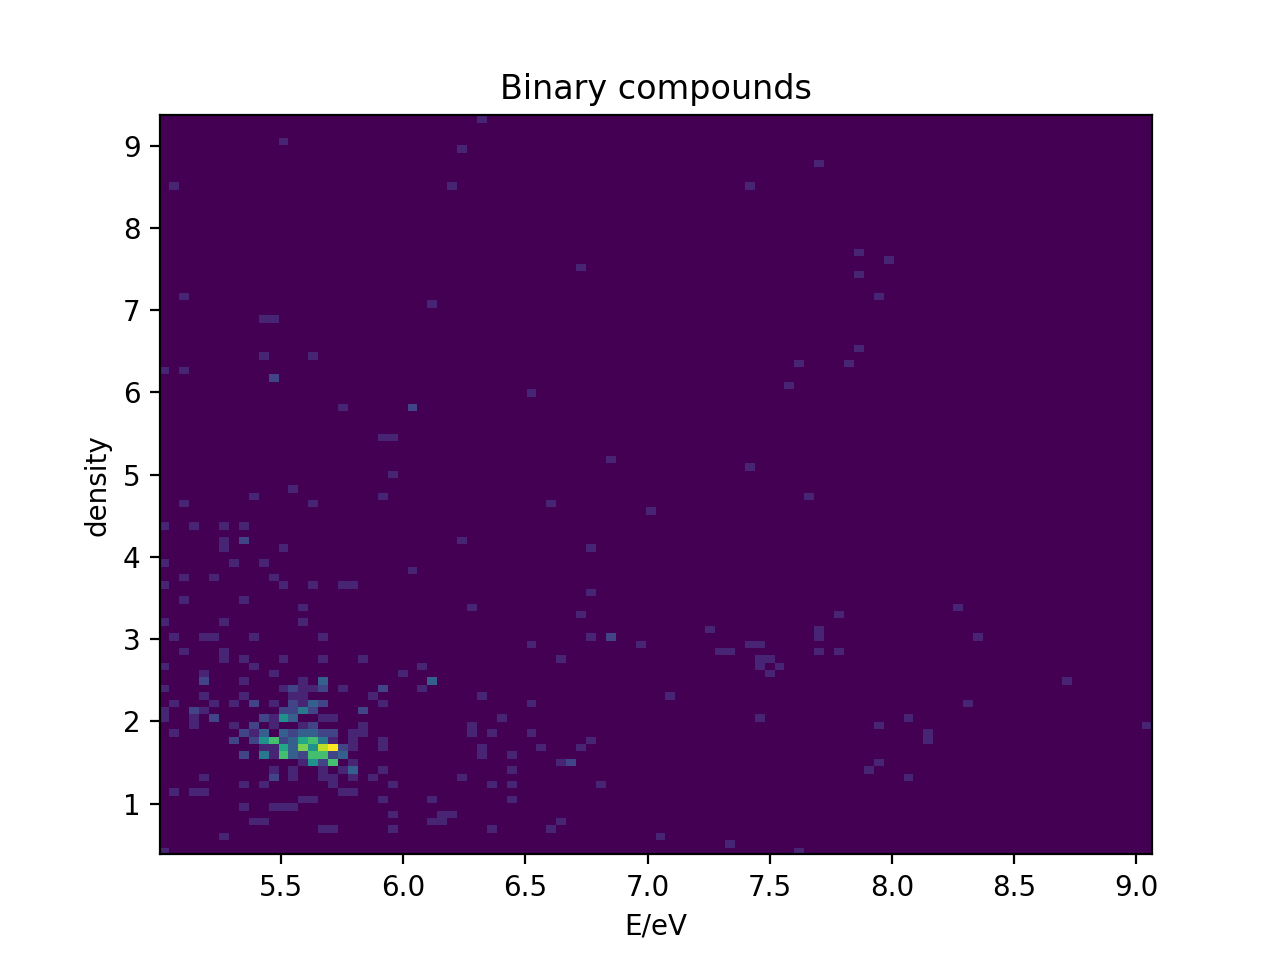

In [86]:
plt.figure()
plt.hist2d(results['band_gap'], results['density'], bins=100)
plt.xlabel('E/eV')
plt.ylabel('density')
plt.title('Binary compounds')
plt.show()